In [28]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.collections as PatchCollection
import matplotlib.patches as mpatches
import pickle
import alu_dataset

from plain_net.PlainNet import PlainNet
from soft_thresholding.SoftThresholdNet import SoftThresholdNet
from L1_regularization.L1RegularizationNet import L1RegularizationNet
from dynamic_sparse_reparameterization.DynamicSparseReparameterizationNet import DynamicSparseReparameterizationNet
from magnitude_pruning.MagnitudePruning import MagnitudePruningNet

from tqdm import tqdm

from utils import load_data, load_models, MulticolorPatch, MulticolorPatchHandler, load_state_dicts, create_models

In [29]:
# Load data
dataset = "alu" # alu or duffing

# Load train and val data as dataloaders
train_loader, val_loader, test_loader = load_data(f"data/{dataset}")

# Load test data sets
with open("data/alu/test_data.pickle", "rb") as f:
    test_data = pickle.load(f)
    
dt = train_loader.dataset.DT

test_loader = DataLoader(alu_dataset.Dataset_alu(test_data, dt), shuffle=False)

y_std = test_loader.dataset.y_std
y_mean = test_loader.dataset.y_mean
x_std = test_loader.dataset.x_std
x_mean = test_loader.dataset.x_mean

In [30]:
test_set_n = 13
x_test = test_data[test_set_n]

#x_mean = x_test_mean
#x_std = test.x_std
#y_mean = test.y_mean
#y_std = test.y_std

t = torch.linspace(0, dt * len(x_test)/60/60, len(x_test))

In [63]:
path = "models/alu/L1_regularization/best_model" # plain, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning

models = load_models(path, n_models=1)

path = "models/alu/L1_regularization/best_swa_model"
state_dicts = load_state_dicts(path, n_models=1)
layers = [13, 25, 25, 25, 25, 8]
#models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(L1RegularizationNet(layers))
    model.load_state_dict(state_dict)
    models.append(model)

RuntimeError: Error(s) in loading state_dict for AveragedModel:
	size mismatch for module.layers.0.weight: copying a param with shape torch.Size([25, 13]) from checkpoint, the shape in current model is torch.Size([64, 13]).
	size mismatch for module.layers.0.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for module.layers.1.weight: copying a param with shape torch.Size([25, 25]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for module.layers.1.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for module.layers.2.weight: copying a param with shape torch.Size([25, 25]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for module.layers.2.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for module.layers.3.weight: copying a param with shape torch.Size([25, 25]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for module.layers.3.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for module.layers.4.weight: copying a param with shape torch.Size([8, 25]) from checkpoint, the shape in current model is torch.Size([8, 64]).

In [64]:
# Make predictions for each model
predictions = []
for model in models:
    prediction = torch.zeros_like(x_test).detach()
    prediction[:, 8:] = x_test[:, 8:]
    prediction[:1] = x_test[:1]
    predictions.append(prediction.detach().numpy())

    for i in range(1, len(prediction)):
        input = (prediction[i-1] - x_mean) / x_std
        x_dot = model(input) * y_std + y_mean
        prediction[i, :8] = prediction[i-1, :8] + x_dot * dt

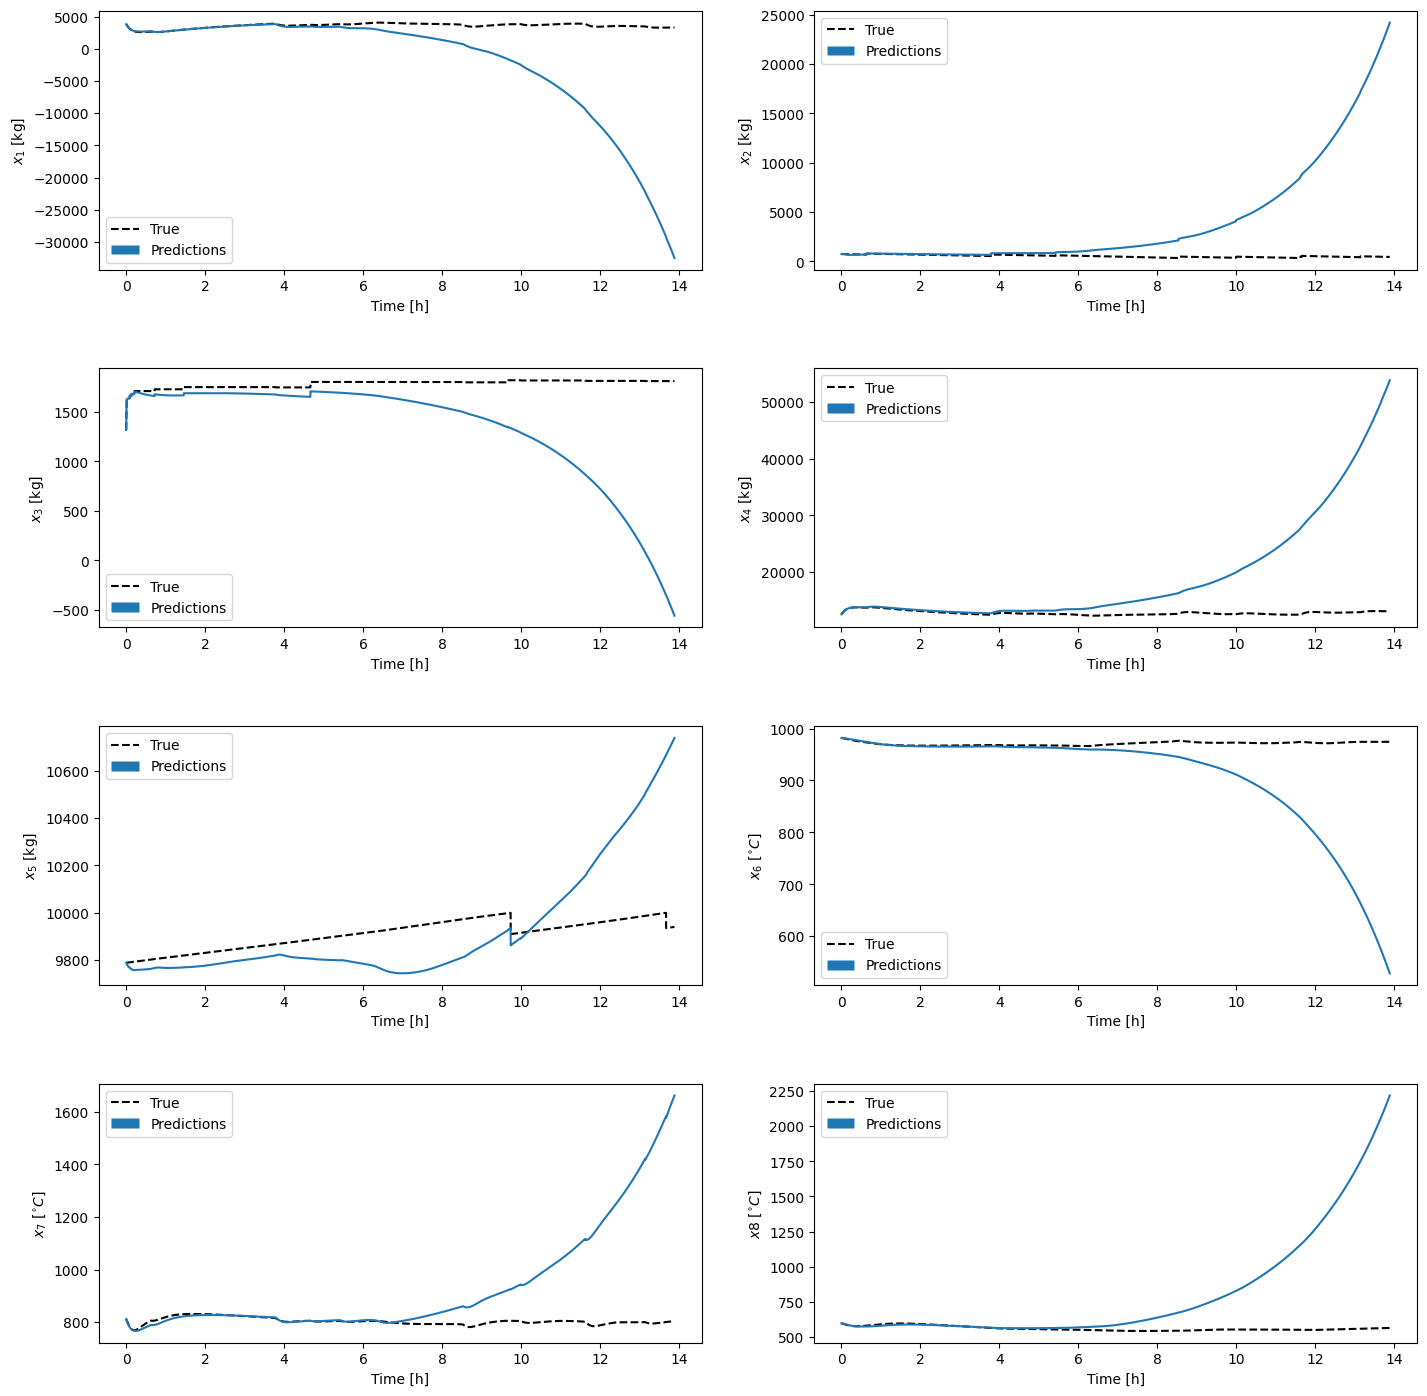

In [65]:
steps = 5000 # Max 5000

y_labels = ["$x_1$ [kg]", "$x_2$ [kg]", "$x_3$ [kg]", "$x_4$ [kg]", "$x_5$ [kg]", "$x_6$ $[^{\circ}C]$", "$x_7$ $[^{\circ}C]$", "$x8$ $[^{\circ}C]$"]
x_label = "Time [h]"

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i in range(8):
    colors = []
    ax[i//2, i%2].plot(t[:steps], x_test[:steps, i], label="True", color="black", linestyle="--")
    for prediction in predictions:
        ax[i//2, i%2].plot(t[:steps], prediction[:steps, i])
        colors.append(ax[i//2, i%2].lines[-1].get_color())
    ax[i//2, i%2].set_ylabel(y_labels[i])
    ax[i//2, i%2].set_xlabel(x_label)
    #ax[i//2, i%2].set_title(f"State {i+1}")
    h, l = ax[0//2, 0%2].get_legend_handles_labels()
    h.append(MulticolorPatch(colors))
    l.append("Predictions")
    ax[i//2, i%2].legend(h, l,
         handler_map={MulticolorPatch: MulticolorPatchHandler()})

In [34]:
mean_prediction = torch.zeros_like(x_test).detach()
for prediction in predictions:
    mean_prediction += prediction
mean_prediction /= len(predictions)

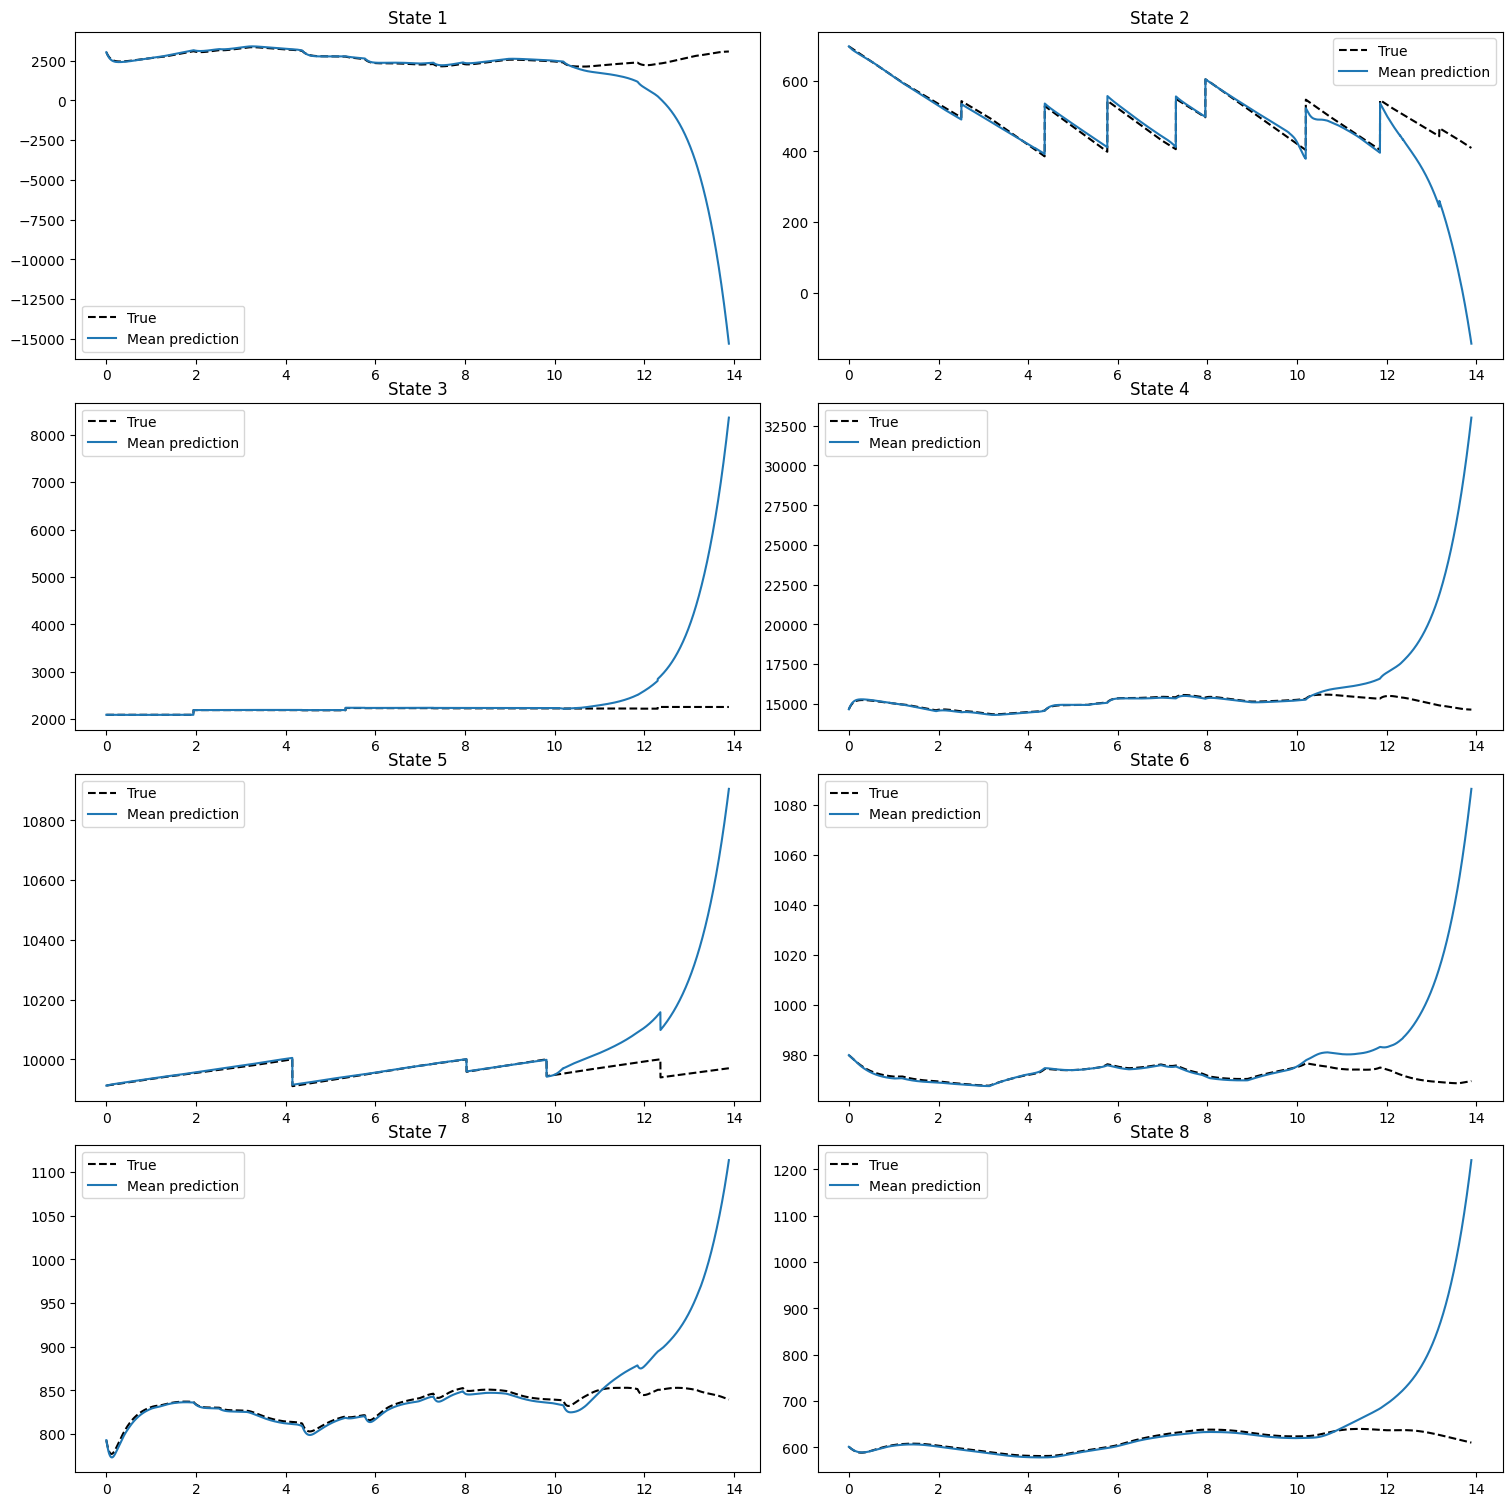

In [35]:
steps = 4999 # Max 4999

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
fig.tight_layout()
for i in range(8):
    ax[i//2, i%2].plot(t[:steps], x_test[:steps, i], label="True", color="black", linestyle="--")
    ax[i//2, i%2].plot(t[:steps], mean_prediction[:steps, i].detach(), label="Mean prediction")
    ax[i//2, i%2].set_title(f"State {i+1}")
    ax[i//2, i%2].legend()

In [36]:
error = []
for x_test in tqdm(test_data):
    for model in models:
        prediction = torch.zeros_like(x_test).detach()
        prediction[:, 8:] = x_test[:, 8:]
        prediction[:1] = x_test[:1]

        for i in range(1, len(prediction)):
            input = (prediction[i-1] - x_mean) / x_std
            x_dot = model(input) * y_std + y_mean
            prediction[i, :8] = prediction[i-1, :8] + x_dot * dt
        error.append(torch.mean(torch.abs(prediction - x_test)).item())

100%|██████████| 40/40 [02:40<00:00,  4.00s/it]


In [37]:
error_dict = dict()
for n, e in enumerate(error):
    error_dict[n] = e

# Sort error dict after error
error_dict = {k: v for k, v in sorted(error_dict.items(), key=lambda item: item[1])}